# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [21]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [11]:
HCP_DIR = "./hcp"

# Basic parameters

In [9]:

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [13]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  print('wget is done')  
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

wget is done


In [14]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  print('wget is done')  
  !tar -xzf $fname -C $HCP_DIR --strip-components=1
  print('tar is done')  

wget is done
tar is done


In [15]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  print('wget is done')  
  !tar -xzf $fname -C $HCP_DIR --strip-components=1
  print('tar is done')  

wget is done
tar is done


## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [12]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

# Helper functions


## Data loading

In [22]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

## Task-based analysis

In [18]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting-state analyses

Load a single run of resting-state data:

In [26]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [ ]:
timeseries = load_timeseries(subject=0, name="rest", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [29]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "rest", concat=False)
  timeseries_rest.append(ts_concat)

In [30]:
np.asarray(timeseries_rest).shape

(339, 4, 360, 1200)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

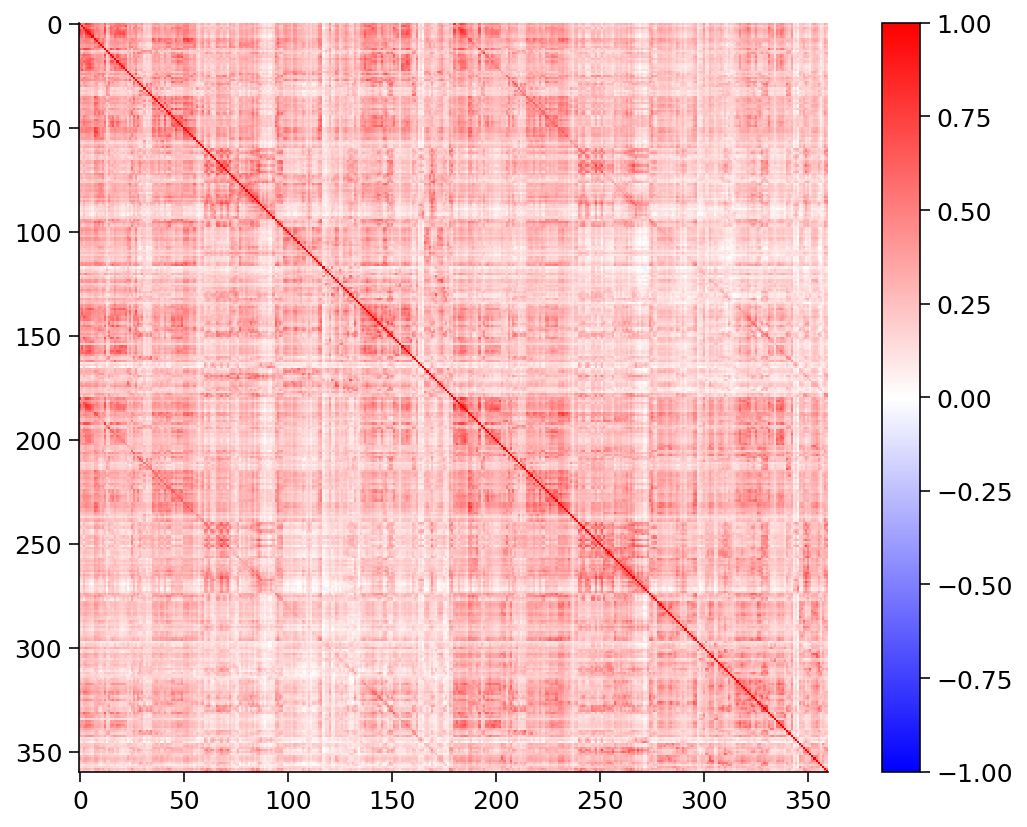

In [ ]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  # ts shape is 360 for 4800
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

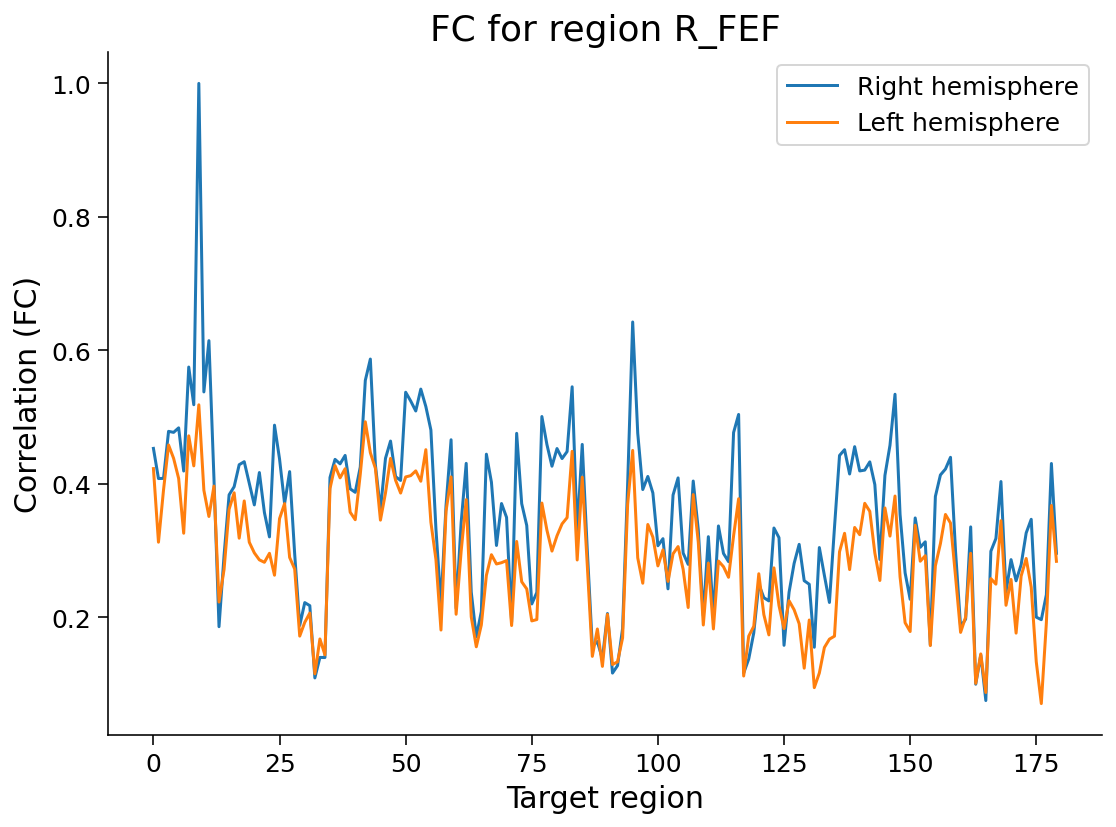

In [ ]:
seed_roi = "R_FEF"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [31]:
timeseries_task_motor = []
for subject in subjects:
  timeseries_task_motor.append(load_timeseries(subject, "motor"))

In [32]:
timeseries_task_lang = []
for subject in subjects:
  timeseries_task_lang.append(load_timeseries(subject, "language"))

## Run a simple subtraction analysis

In [ ]:
help(load_evs)

Help on function load_evs in module __main__:

load_evs(subject, name, condition)
    Load EV (explanatory variable) data for one task condition.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of task
      condition (str) : Name of condition
    
    Returns
      evs (list of dicts): A dictionary with the onset, duration, and amplitude
        of the condition for each run.



In [ ]:
help(selective_average)

Help on function selective_average in module __main__:

selective_average(timeseries_data, ev, skip=0)
    Take the temporal mean across frames for a given condition.
    
    Args:
      timeseries_data (array or list of arrays): n_parcel x n_tp arrays
      ev (dict or list of dicts): Condition timing information
      skip (int) : Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    
    Returns:
      avg_data (1D array): Data averagted across selected image frames based
      on condition timing



In [ ]:
task = "motor"
conditions = ["lf", "rf"]  # Run a substraction analysis between two conditions

contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

group_contrast = np.mean(contrast, axis=0)

Plot group-averaged contrast value across regions:

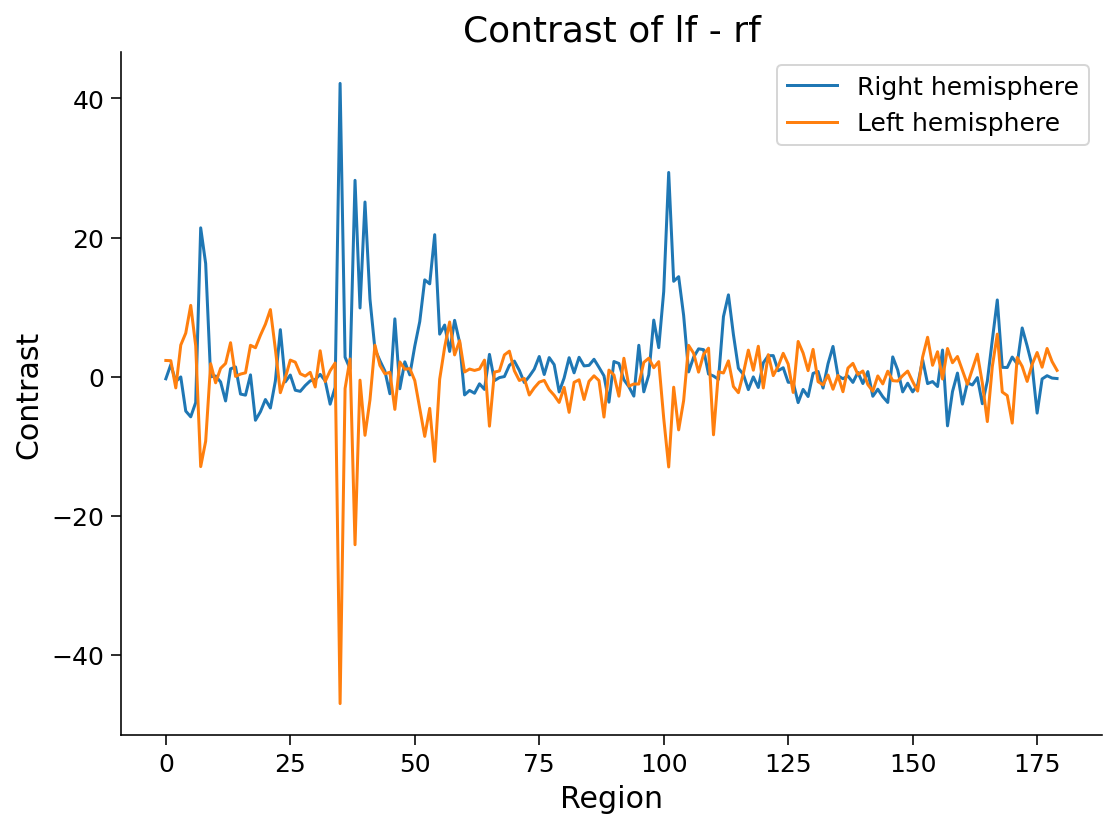

In [ ]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

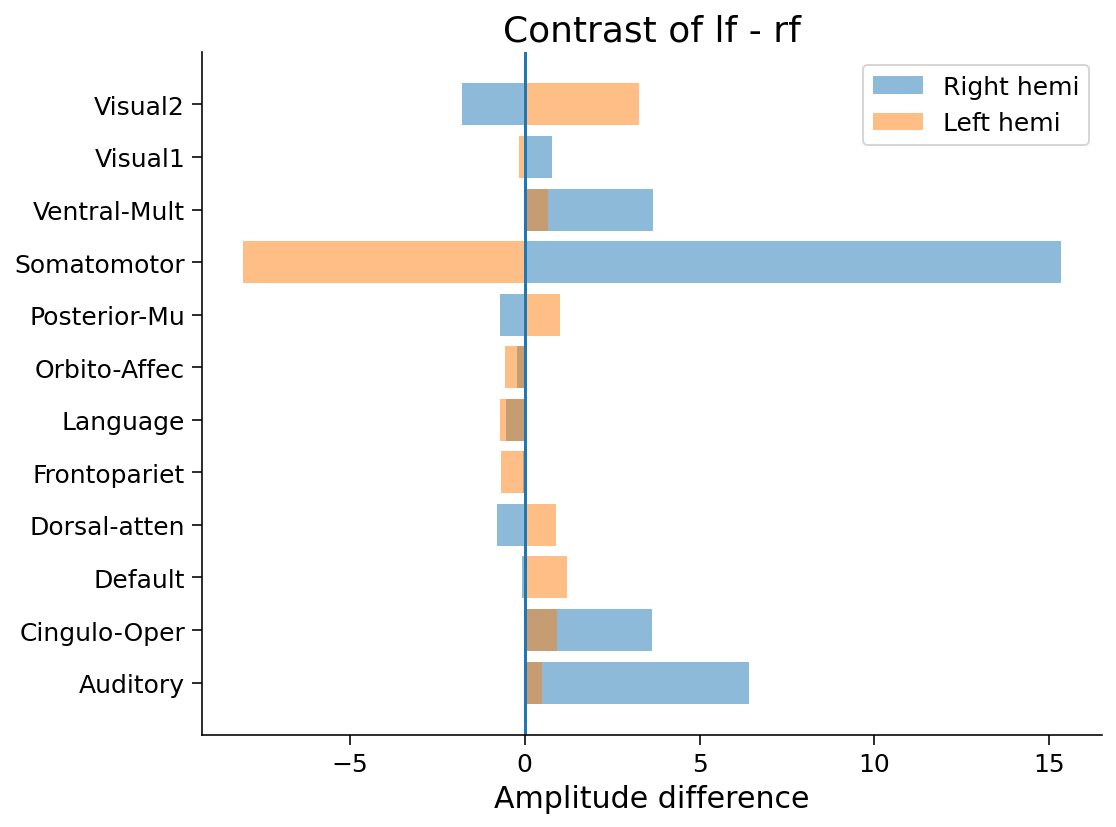

In [ ]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [ ]:
wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load("hcp/pseudo_demographics.npy")
demo.shape

(339, 25)

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [ ]:
ids = np.loadtxt("hcp/orig_ids.txt")
print(ids[:8])

[199453. 580751. 173435. 919966. 181636. 192843. 894067. 174437.]


## My part
based on https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

###Granger Causality -> Code from http://nipy.org/nitime/examples/granger_fmri.html 

In [40]:
! pip install nitime

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
import datetime
import nitime
import nitime.analysis as nta
import nitime.timeseries as ts
import nitime.utils as tsu
from nitime.viz import drawmatrix_channels
import multiprocessing as mp
from seaborn import heatmap
import datetime
import seaborn as sns
import pandas as pd
import multiprocessing as mp

/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [6]:
f_ub = 0.15
f_lb = 0.02

coh_av = []
g1_av = []
g2_av = []
Gs = []
C1s = []
C2s = [] 
corrs = []


def resting_state_granger(i, task):

  timeseries_rest = load_timeseries(i, task)
  print(f'{i} {task} : {datetime.datetime.now().time()}')
  time_series = ts.TimeSeries(timeseries_rest, sampling_interval=0.7)
  G = nta.GrangerAnalyzer(time_series, order=1)
  C1 = nta.CoherenceAnalyzer(time_series)
  C2 = nta.CorrelationAnalyzer(time_series)
  corrs = C2.corrcoef
  freq_idx_G = np.where((G.frequencies > f_lb) * (G.frequencies < f_ub))[0]
  freq_idx_C = np.where((C1.frequencies > f_lb) * (C1.frequencies < f_ub))[0]
  coh_av = np.mean(C1.coherence[:, :, freq_idx_C], -1)  # Averaging on the last dimension
  g1_av = np.mean(G.causality_xy[:, :, freq_idx_G], -1)
  g2_av = np.mean(G.causality_xy[:, :, freq_idx_G] - G.causality_yx[:, :, freq_idx_G], -1)

  return i, coh_av, g1_av, g2_av, corrs

In [100]:
tasks = ['motor', 'social', 'wm', 'gambling', 'relational', 'emotion', 'language', 'rest']

In [104]:
# from itertools import product


# for t in tasks:
#     print(f'{t} IS STARTED')
#     with mp.Pool(6) as pool:
#       outputs = pool.starmap(resting_state_granger, product(range(339), [t]))
#     print(f'{t} IS FINISHED')
#     nums, coh_av_, g1_av_, g2_av_, corrs_ = map(list, zip(*outputs))
#     np.save(f"{t}/g1_av", np.asarray(g1_av_).reshape((N_SUBJECTS, N_PARCELS, N_PARCELS)))
#     np.save(f"{t}/numbers", np.asarray(nums))
#     np.save(f"{t}/g2_av", np.asarray(g2_av_).reshape((N_SUBJECTS, N_PARCELS, N_PARCELS)))
#     np.save(f"{t}/corrs", np.asarray(corrs_).reshape((N_SUBJECTS, N_PARCELS, N_PARCELS)))
#     np.save(f"{t}/coh_av", np.asarray(coh_av_).reshape((N_SUBJECTS, N_PARCELS, N_PARCELS)))
#     print(f'{t} IS SAVED')

motor IS STARTED
60 motor : 23:47:06.865529
0 motor : 23:47:06.865046
45 motor : 23:47:06.865184
75 motor : 23:47:06.863878
30 motor : 23:47:06.864608
15 motor : 23:47:06.865184
16 motor : 23:50:14.028401
76 motor : 23:51:58.365293
61 motor : 23:52:29.367075
1 motor : 23:52:30.419297
46 motor : 23:52:31.368710
31 motor : 23:52:36.686157
17 motor : 23:53:35.395417
77 motor : 23:54:55.498508
32 motor : 23:57:09.108163
47 motor : 23:57:37.268788
18 motor : 23:57:50.255278
62 motor : 23:57:50.630184
2 motor : 23:57:56.576452
78 motor : 23:57:58.418789
33 motor : 23:59:43.516211
48 motor : 00:00:21.093806
3 motor : 00:00:39.021958
19 motor : 00:00:41.347139
63 motor : 00:00:47.794486
79 motor : 00:01:19.755095
49 motor : 00:04:21.758170
34 motor : 00:04:21.802198
64 motor : 00:04:36.030366
20 motor : 00:04:36.179670
4 motor : 00:04:36.196250
80 motor : 00:04:40.386531
50 motor : 00:06:51.407155
65 motor : 00:07:19.734902
5 motor : 00:07:19.910132
81 motor : 00:07:29.636833
21 motor : 00:07:

305 motor : 02:22:01.251456
291 motor : 02:22:32.037799
333 motor : 02:22:36.881104
277 motor : 02:22:40.447982
320 motor : 02:22:49.829000
306 motor : 02:24:42.966496
278 motor : 02:24:46.093460
321 motor : 02:25:07.434675
334 motor : 02:25:12.285647
292 motor : 02:25:33.019569
322 motor : 02:27:05.882962
307 motor : 02:27:39.322952
279 motor : 02:28:03.501389
335 motor : 02:28:03.624254
293 motor : 02:28:03.853353
323 motor : 02:29:49.863929
294 motor : 02:30:04.231786
336 motor : 02:30:07.160290
308 motor : 02:30:51.127066
280 motor : 02:31:06.016964
324 motor : 02:31:57.438359
295 motor : 02:32:42.663644
337 motor : 02:32:46.916419
325 motor : 02:34:04.910915
309 motor : 02:34:10.416894
281 motor : 02:34:10.731208
296 motor : 02:35:15.150900
338 motor : 02:35:50.933563
326 motor : 02:37:03.590470
310 motor : 02:37:03.777867
282 motor : 02:37:26.942797
297 motor : 02:38:18.241120
283 motor : 02:39:58.820099
311 motor : 02:40:00.997180
327 motor : 02:40:04.826449
298 motor : 02:40:37

236 social : 04:49:32.862099
206 social : 04:50:37.866528
265 social : 04:50:38.000020
221 social : 04:50:38.019510
191 social : 04:50:47.487609
250 social : 04:51:03.146452
237 social : 04:51:51.756400
266 social : 04:52:51.057743
207 social : 04:53:02.918963
222 social : 04:53:03.099401
192 social : 04:53:15.498982
251 social : 04:53:44.275562
238 social : 04:55:15.016624
267 social : 04:55:35.041711
208 social : 04:55:39.213001
223 social : 04:55:40.289783
252 social : 04:56:12.260423
193 social : 04:56:12.553405
268 social : 04:58:46.759380
224 social : 04:58:46.792585
209 social : 04:59:00.266215
194 social : 04:59:04.400728
253 social : 04:59:04.568383
239 social : 04:59:05.468373
269 social : 05:01:43.574660
270 social : 05:01:44.562628
285 social : 05:02:01.016710
254 social : 05:02:04.453086
300 social : 05:02:05.346857
315 social : 05:02:07.150102
330 social : 05:04:08.584719
286 social : 05:04:37.439296
316 social : 05:04:51.251231
301 social : 05:04:54.330391
271 social : 0

246 wm : 07:27:53.925359
261 wm : 07:28:36.445949
187 wm : 07:29:06.054196
202 wm : 07:29:26.828583
217 wm : 07:29:30.854509
247 wm : 07:30:17.593464
232 wm : 07:30:28.754244
262 wm : 07:30:59.982938
203 wm : 07:31:49.439565
188 wm : 07:31:51.350285
218 wm : 07:32:35.195630
248 wm : 07:33:41.257610
233 wm : 07:34:02.637857
263 wm : 07:34:45.462835
189 wm : 07:34:46.113526
204 wm : 07:34:52.786614
219 wm : 07:35:11.199425
249 wm : 07:36:53.195630
264 wm : 07:37:13.966578
205 wm : 07:37:19.231654
190 wm : 07:37:21.107696
234 wm : 07:37:43.586675
220 wm : 07:37:51.343709
250 wm : 07:39:31.305609
265 wm : 07:39:55.042079
206 wm : 07:40:05.268545
191 wm : 07:40:07.415282
235 wm : 07:40:18.930938
221 wm : 07:40:46.361209
251 wm : 07:42:03.965575
192 wm : 07:42:34.736968
207 wm : 07:42:38.981470
236 wm : 07:42:44.169829
266 wm : 07:42:46.282825
222 wm : 07:43:57.501073
252 wm : 07:44:25.556239
193 wm : 07:44:47.076469
267 wm : 07:45:08.356787
208 wm : 07:45:08.376143
237 wm : 07:45:17.122200


133 gambling : 09:56:04.404066
162 gambling : 09:56:04.877768
147 gambling : 09:56:08.545609
179 gambling : 09:58:09.223914
163 gambling : 09:58:52.016668
180 gambling : 09:58:53.081178
134 gambling : 09:59:00.176411
195 gambling : 09:59:01.872411
148 gambling : 09:59:02.723644
210 gambling : 10:00:30.232985
181 gambling : 10:01:29.698486
196 gambling : 10:01:37.206970
149 gambling : 10:01:40.681116
164 gambling : 10:02:21.043925
225 gambling : 10:02:25.988492
182 gambling : 10:04:49.709944
240 gambling : 10:04:50.122270
197 gambling : 10:05:04.332249
211 gambling : 10:05:04.680100
226 gambling : 10:05:07.612482
255 gambling : 10:05:08.413296
241 gambling : 10:07:55.431754
183 gambling : 10:07:55.641396
212 gambling : 10:08:07.001778
198 gambling : 10:08:07.039835
256 gambling : 10:08:07.123752
227 gambling : 10:08:15.485219
242 gambling : 10:10:32.005080
213 gambling : 10:10:40.159067
228 gambling : 10:10:46.258821
184 gambling : 10:10:51.341513
199 gambling : 10:11:16.644636
257 gamb

120 relational : 12:14:01.522545
135 relational : 12:14:05.341975
91 relational : 12:14:34.916066
150 relational : 12:14:35.651105
165 relational : 12:14:36.215052
121 relational : 12:17:05.076639
136 relational : 12:17:05.076797
106 relational : 12:17:11.235316
92 relational : 12:17:18.548977
151 relational : 12:17:29.026591
166 relational : 12:17:50.055347
137 relational : 12:19:25.632537
107 relational : 12:19:41.415483
122 relational : 12:19:49.931575
93 relational : 12:20:05.261974
167 relational : 12:20:17.389594
152 relational : 12:20:32.012116
138 relational : 12:21:40.405834
108 relational : 12:22:02.513803
123 relational : 12:22:11.585265
94 relational : 12:22:59.212184
153 relational : 12:23:44.105173
168 relational : 12:24:00.657874
139 relational : 12:24:08.608873
109 relational : 12:24:33.808506
124 relational : 12:25:37.506208
95 relational : 12:25:47.429512
154 relational : 12:26:17.166815
169 relational : 12:26:21.498354
140 relational : 12:26:50.636625
110 relational 

15 emotion : 14:19:29.988419
75 emotion : 14:19:29.988472
45 emotion : 14:19:29.988462
60 emotion : 14:19:29.988466
30 emotion : 14:19:29.988449
0 emotion : 14:19:29.988455
1 emotion : 14:22:39.992795
46 emotion : 14:22:40.101100
61 emotion : 14:22:40.355344
31 emotion : 14:22:47.731273
76 emotion : 14:22:47.939295
16 emotion : 14:22:50.301653
2 emotion : 14:25:31.502908
47 emotion : 14:25:31.513989
32 emotion : 14:25:53.793214
17 emotion : 14:25:54.025801
77 emotion : 14:26:02.283519
62 emotion : 14:26:21.289061
48 emotion : 14:28:15.296485
18 emotion : 14:29:03.694953
33 emotion : 14:29:07.801328
3 emotion : 14:29:08.307470
63 emotion : 14:29:11.524510
78 emotion : 14:29:11.874657
4 emotion : 14:32:15.753805
34 emotion : 14:32:15.746713
64 emotion : 14:32:28.542639
19 emotion : 14:32:28.627129
49 emotion : 14:32:28.871579
79 emotion : 14:32:32.709141
5 emotion : 14:35:35.155934
35 emotion : 14:35:35.290127
20 emotion : 14:35:44.552899
65 emotion : 14:35:44.624347
50 emotion : 14:35:4

269 emotion : 16:32:09.533782
272 emotion : 16:34:17.680124
316 emotion : 16:34:24.673625
302 emotion : 16:34:39.256182
331 emotion : 16:34:39.272681
287 emotion : 16:35:02.327628
288 emotion : 16:37:25.115165
303 emotion : 16:37:38.171267
332 emotion : 16:37:42.100321
273 emotion : 16:37:42.415238
317 emotion : 16:37:48.371826
333 emotion : 16:39:56.776054
274 emotion : 16:40:39.667010
304 emotion : 16:40:56.156757
318 emotion : 16:40:56.623287
289 emotion : 16:40:57.973561
334 emotion : 16:42:19.896123
290 emotion : 16:43:13.551258
305 emotion : 16:43:31.202950
275 emotion : 16:43:40.748589
319 emotion : 16:43:54.947566
335 emotion : 16:44:11.667001
306 emotion : 16:45:53.304884
291 emotion : 16:46:03.574828
276 emotion : 16:46:14.444621
336 emotion : 16:46:15.497634
320 emotion : 16:46:44.725387
292 emotion : 16:48:17.604513
307 emotion : 16:48:48.470582
321 emotion : 16:48:49.104989
277 emotion : 16:49:12.239066
337 emotion : 16:49:28.768110
293 emotion : 16:50:22.040118
308 emotio

In [7]:
def load_one(filename, average=True):
    file = np.load(f'{filename}.npy')
#     remove nans
    file [np.isnan(file)]=0
    if average:
        file = np.mean(file, axis=0)
    return file

def draw_half_heatmap(data, size):
    df = pd.DataFrame(data, columns=regions[0], index=regions[0])
    mask = np.zeros_like(df.T)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=size)
        ax = sns.heatmap(df.T, mask=mask, vmax=.3, square=True)

In [13]:
wm = load_one('wm/g1_av')

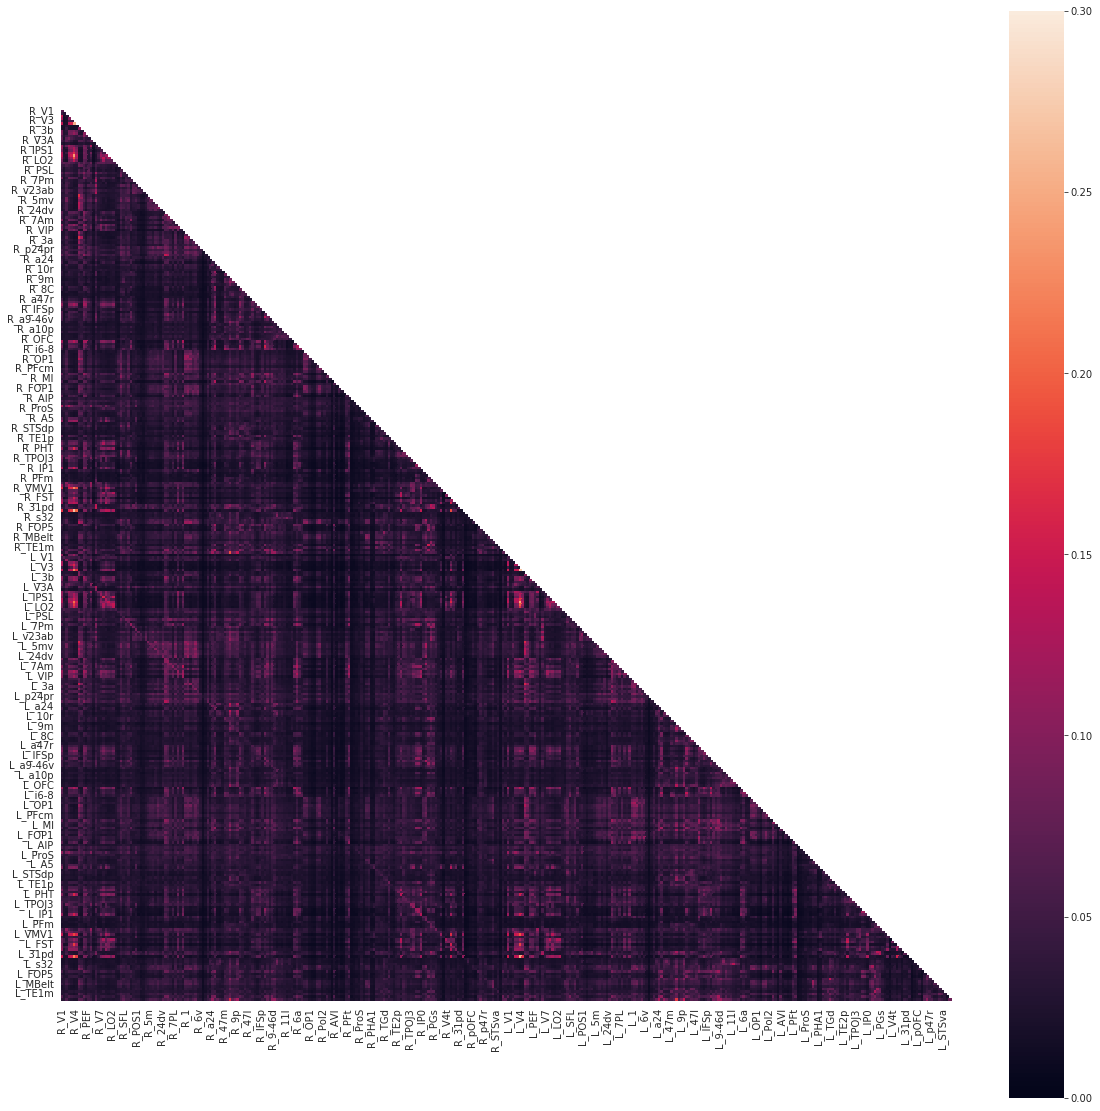

In [14]:
draw_half_heatmap(wm,(20, 20))

/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


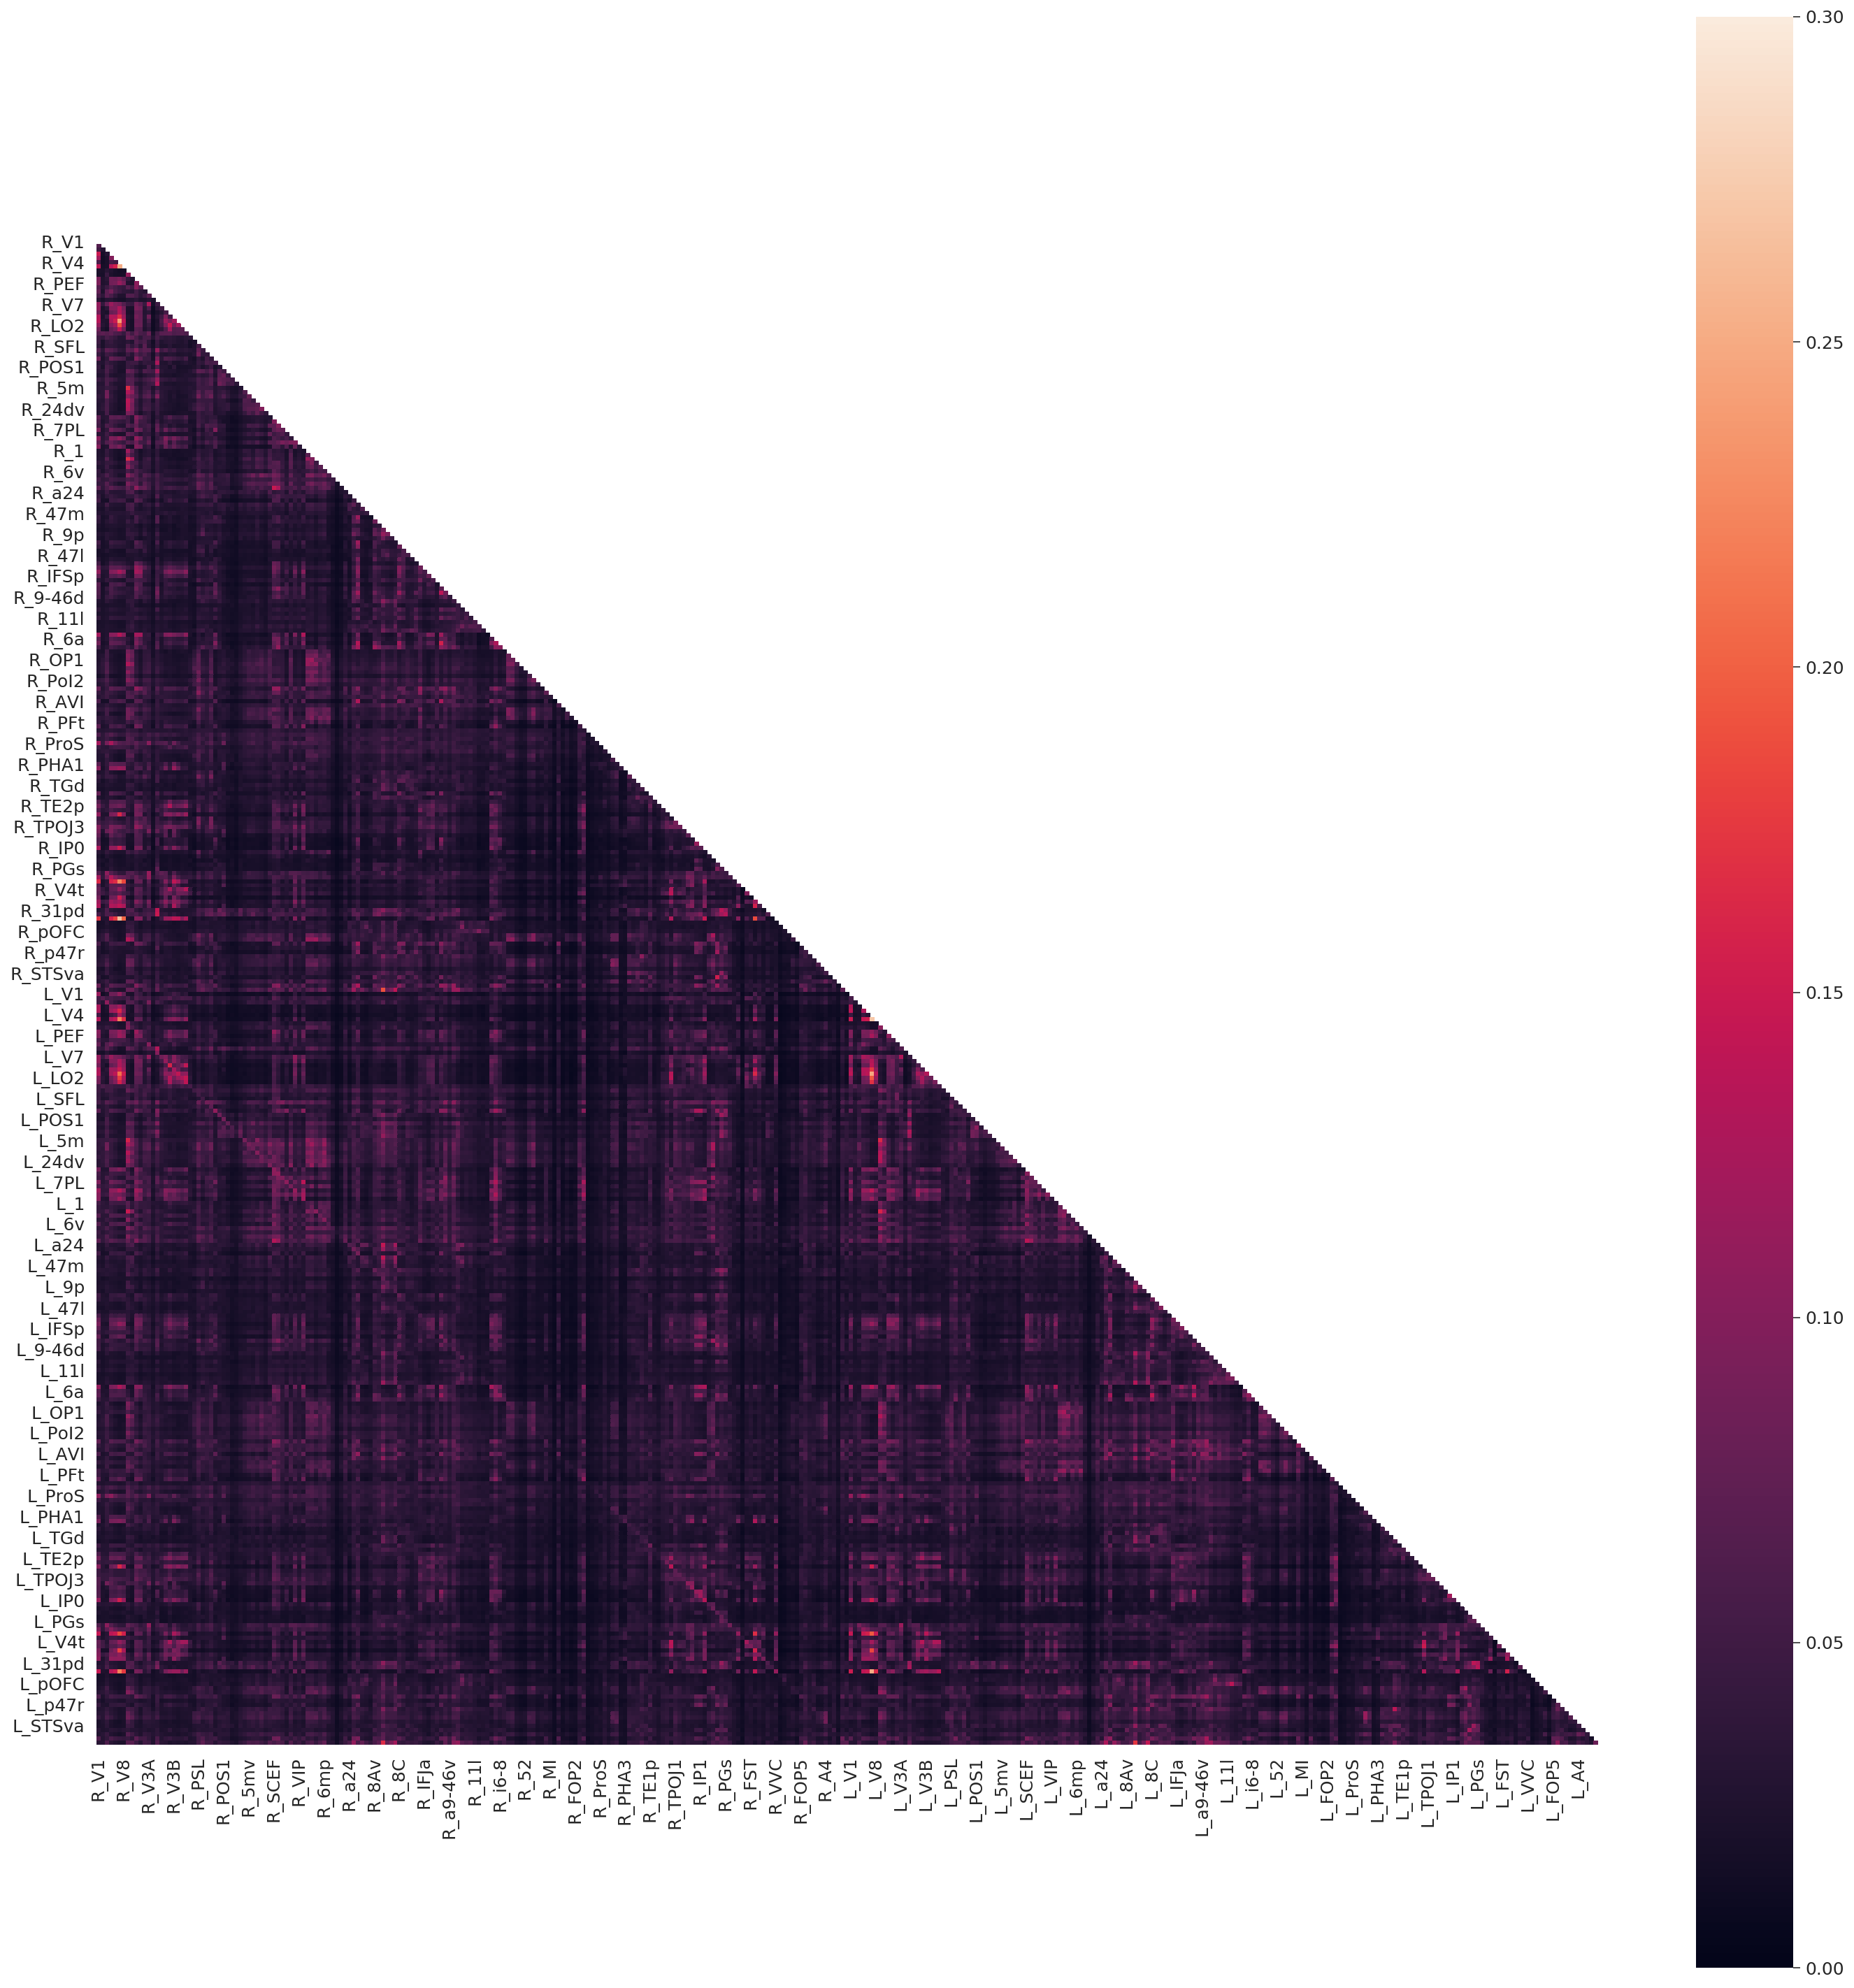

In [150]:
df = pd.DataFrame(wm, columns=regions[0], index=regions[0])

mask = np.zeros_like(df.T)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(df.T, mask=mask, vmax=.3, square=True)

/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


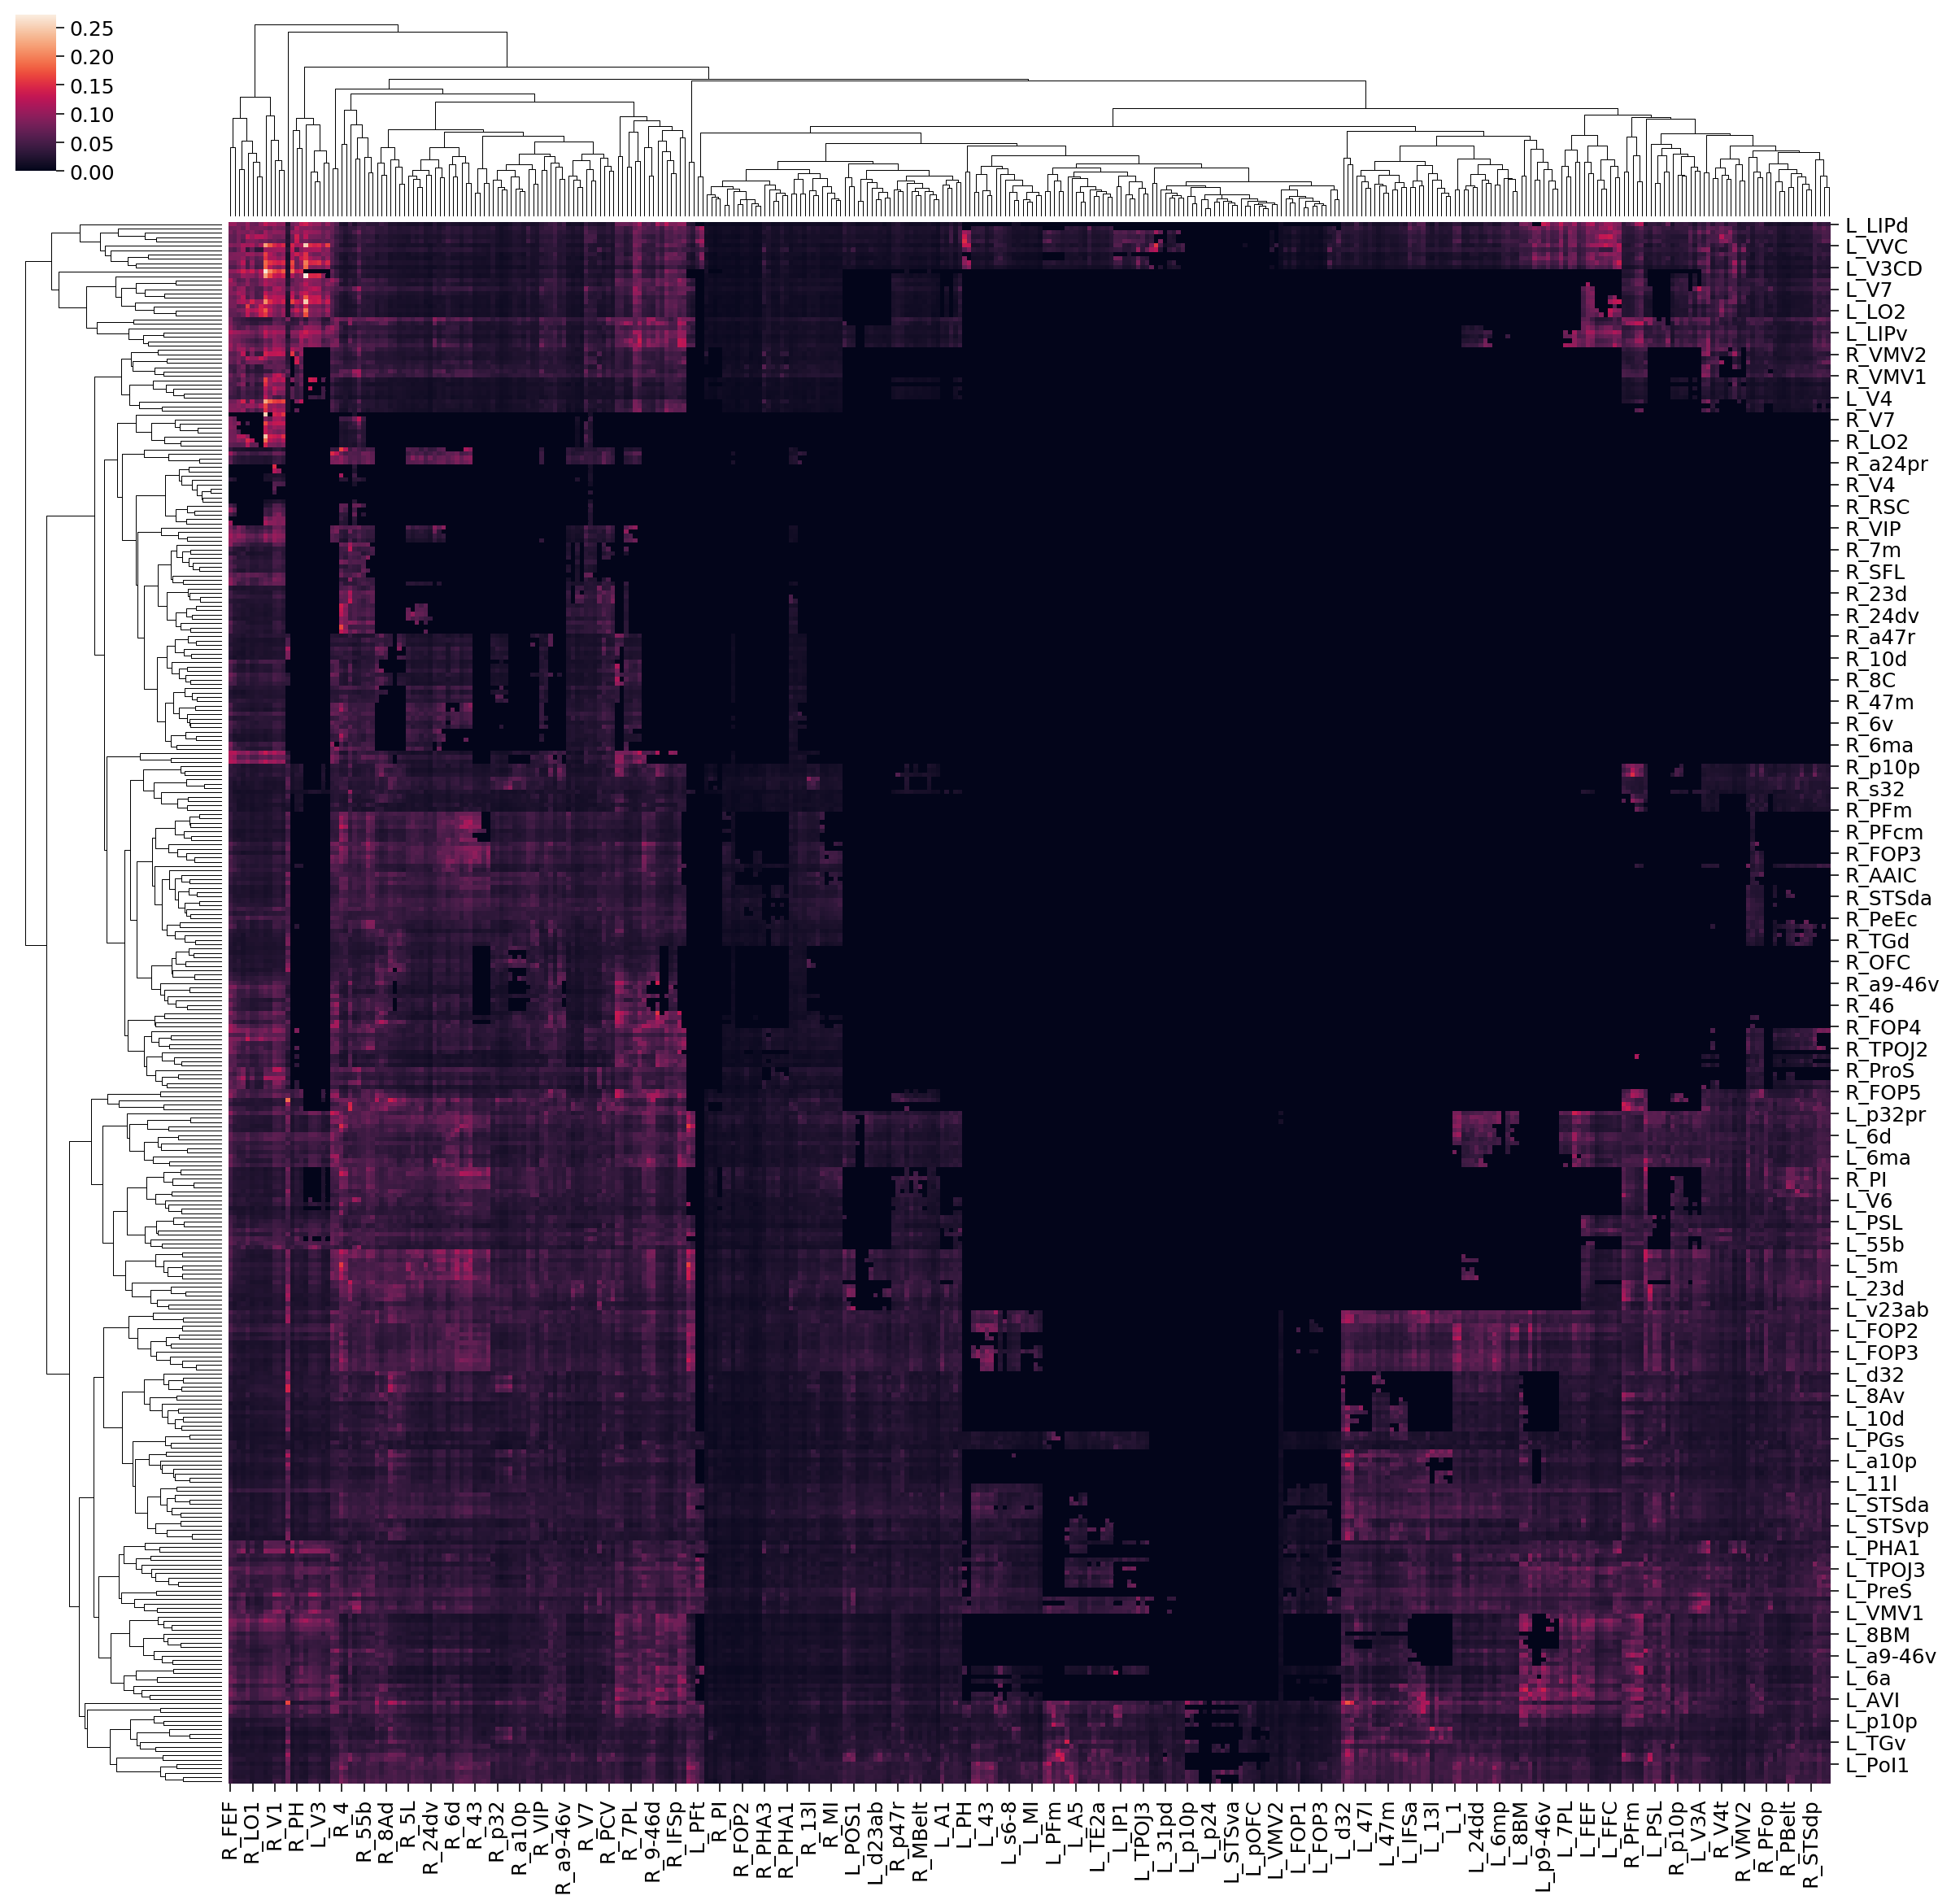

In [156]:
sns.clustermap(df.T, figsize=(20,20) )

/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


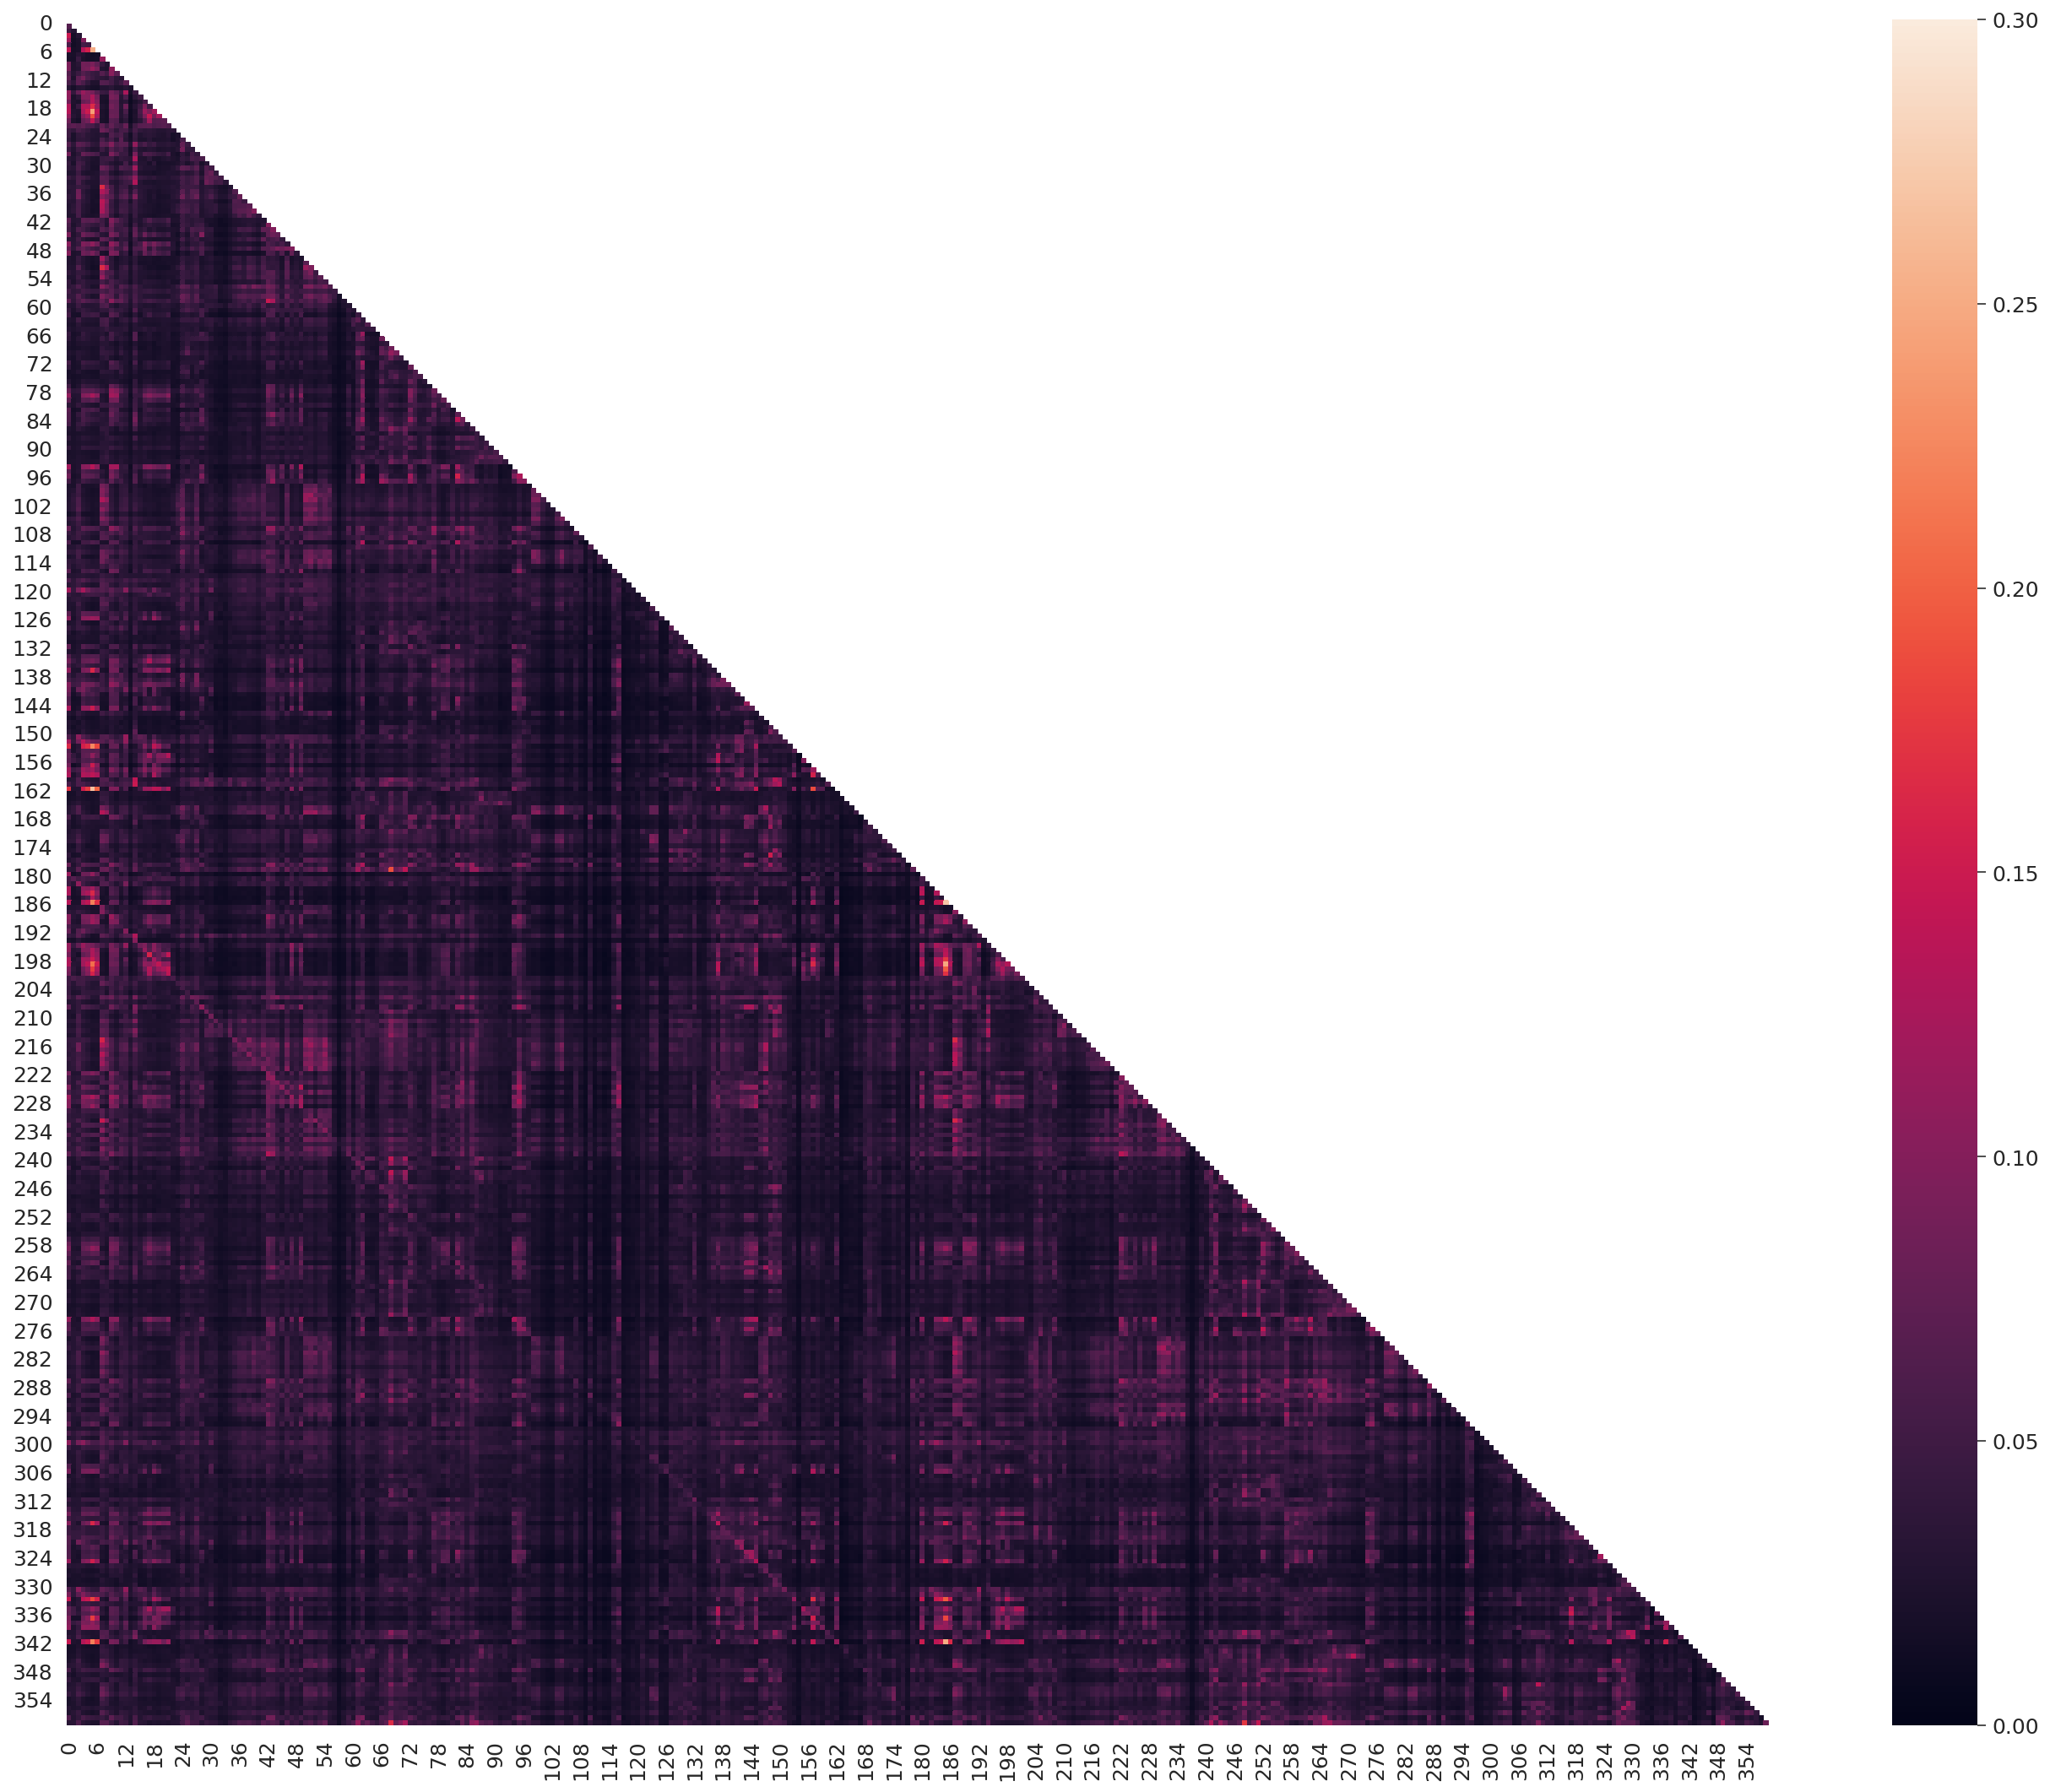

In [151]:
mask = np.zeros_like(wm.T)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(wm.T, mask=mask, vmax=.3, square=True)

Ways to speed up python https://colab.research.google.com/drive/1nMDtWcVZCT9q1VWen5rXL8ZHVlxn2KnL#scrollTo=LNR1Ko74Jv3- 

##Test Multiprocessing
* 16.6.1.4. Sharing state between processes https://docs.python.org/2/library/multiprocessing.html#introduction 


Maybe look after what Johansen function is https://nbviewer.jupyter.org/github/mapsa/seminario-doc-2014/blob/master/cointegration-example.ipynb   

Note on multiprocessing - do not copy data   
360* 360* 339*4 /1024 /1024 ~2200 Mb = 2.2 Ggb and RAM is only 8 ...
